In [1]:
# Data Loading & Initial Inspection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Load the dataset
file_path = r"D:\Market Projects\options_data_analyzer\Aug '25\Aug 07 Exp\07 Aug\24400CE.csv"

# Read CSV with proper datetime parsing
df = pd.read_csv(file_path, parse_dates=['date'])

print("=== DATASET LOADED SUCCESSFULLY ===")
print(f"File: 24400CE.csv")
print(f"Path: {file_path}")
print()

# 1. Check data shape
print("=== DATA SHAPE ===")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
print()

# 2. Check data types
print("=== DATA TYPES ===")
print(df.dtypes)
print()

# 3. Check for null/missing values
print("=== NULL VALUES CHECK ===")
null_counts = df.isnull().sum()
if null_counts.sum() == 0:
    print("✅ No null values found in the dataset")
else:
    print("❌ Null values found:")
    print(null_counts[null_counts > 0])
print()

# 4. Preview first few rows
print("=== FIRST 10 ROWS ===")
print(df.head(10))
print()

# 5. Preview last few rows
print("=== LAST 5 ROWS ===")
print(df.tail())
print()

# 6. Basic statistics
print("=== BASIC STATISTICS ===")
print(df.describe())
print()

# 7. Column information
print("=== COLUMN INFORMATION ===")
print("Columns in the dataset:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")
print()

# 8. Date range information
print("=== DATE RANGE ===")
print(f"Start Date: {df['date'].min()}")
print(f"End Date: {df['date'].max()}")
print(f"Total Time Span: {df['date'].max() - df['date'].min()}")
print()

# 9. Memory usage
print("=== MEMORY USAGE ===")
memory_usage = df.memory_usage(deep=True)
print(f"Total Memory Usage: {memory_usage.sum() / 1024 / 1024:.2f} MB")
print("Memory usage per column:")
for col in df.columns:
    print(f"  {col}: {memory_usage[col] / 1024:.2f} KB")

print("\n" + "="*50)
print("✅ DATASET READY FOR ANALYSIS")
print("="*50)

=== DATASET LOADED SUCCESSFULLY ===
File: 24400CE.csv
Path: D:\Market Projects\options_data_analyzer\Aug '25\Aug 07 Exp\07 Aug\24400CE.csv

=== DATA SHAPE ===
Rows: 64,430
Columns: 5

=== DATA TYPES ===
date         datetime64[ns]
price               float64
qty                   int64
trnvr               float64
cum_trnvr           float64
dtype: object

=== NULL VALUES CHECK ===
✅ No null values found in the dataset

=== FIRST 10 ROWS ===
                 date   price   qty       trnvr   cum_trnvr
0 2025-08-07 09:15:00  132.40  1125   148950.00   148950.00
1 2025-08-07 09:15:00  132.55     0        0.00   148950.00
2 2025-08-07 09:15:00  132.65  1425   189026.25   337976.25
3 2025-08-07 09:15:00  137.20     0        0.00   337976.25
4 2025-08-07 09:15:00  133.80     0        0.00   337976.25
5 2025-08-07 09:15:00  130.90     0        0.00   337976.25
6 2025-08-07 09:15:01  133.60     0        0.00   337976.25
7 2025-08-07 09:15:01  132.70  9525  1263967.50  1601943.75
8 2025-08-07 09

In [2]:
# Data Cleaning & Preprocessing
print("=== DATA CLEANING & PREPROCESSING ===")
print()

# 1. Verify datetime format and convert if needed
print("1. DATETIME PROCESSING")
print(f"Original date column dtype: {df['date'].dtype}")
if df['date'].dtype == 'object':
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %I:%M:%S %p')
    print("✅ Converted date column to datetime")
else:
    print("✅ Date column already in datetime format")
print(f"Final date column dtype: {df['date'].dtype}")
print()

# 2. Check for missing values and handle them
print("2. MISSING VALUES HANDLING")
missing_before = df.isnull().sum()
print("Missing values before cleaning:")
print(missing_before)
print()

# Handle missing values based on domain logic
if missing_before.sum() > 0:
    # For price: forward fill (use last known price)
    if df['price'].isnull().sum() > 0:
        df['price'] = df['price'].fillna(method='ffill')
        print("✅ Forward filled missing prices")
    
    # For qty: fill with 0 (no trade)
    if df['qty'].isnull().sum() > 0:
        df['qty'] = df['qty'].fillna(0)
        print("✅ Filled missing quantities with 0")
    
    # For trnvr: calculate from price * qty if missing
    if df['trnvr'].isnull().sum() > 0:
        df['trnvr'] = df['trnvr'].fillna(df['price'] * df['qty'])
        print("✅ Calculated missing turnover values")
    
    # For cum_trnvr: recalculate cumulative sum
    if df['cum_trnvr'].isnull().sum() > 0:
        df['cum_trnvr'] = df['trnvr'].cumsum()
        print("✅ Recalculated cumulative turnover")

missing_after = df.isnull().sum()
print("Missing values after cleaning:")
print(missing_after)
print()

# 3. Handle zero quantities and prices
print("3. ZERO VALUES ANALYSIS")
zero_qty_count = (df['qty'] == 0).sum()
zero_price_count = (df['price'] == 0).sum()
print(f"Rows with zero quantity: {zero_qty_count:,} ({zero_qty_count/len(df)*100:.2f}%)")
print(f"Rows with zero price: {zero_price_count:,} ({zero_price_count/len(df)*100:.2f}%)")

# For options data, zero quantity might indicate no trades (bid/ask spread)
# Zero price might indicate invalid data
if zero_price_count > 0:
    print("⚠️  Warning: Found rows with zero price - these might be invalid")
    # Option: Remove rows with zero price
    # df = df[df['price'] > 0]
    # print(f"Removed {zero_price_count} rows with zero price")

print()

# 4. Sort data by datetime to maintain chronological order
print("4. SORTING DATA")
print(f"Data sorted before: {df['date'].iloc[0]} to {df['date'].iloc[-1]}")
df = df.sort_values('date').reset_index(drop=True)
print(f"Data sorted after: {df['date'].iloc[0]} to {df['date'].iloc[-1]}")
print("✅ Data sorted chronologically")
print()

# 5. Add derived columns
print("5. ADDING DERIVED COLUMNS")

# Time-based columns
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['time_of_day'] = df['date'].dt.time
df['date_only'] = df['date'].dt.date

# Price change and returns
df['price_change'] = df['price'].diff()
df['price_change_pct'] = df['price'].pct_change() * 100

# Log returns (for financial analysis)
df['log_return'] = np.log(df['price'] / df['price'].shift(1))

# Volume and turnover analysis
df['volume_ma_5'] = df['qty'].rolling(window=5, min_periods=1).mean()
df['price_ma_5'] = df['price'].rolling(window=5, min_periods=1).mean()

# Volatility (rolling standard deviation of returns)
df['volatility_5'] = df['price_change_pct'].rolling(window=5, min_periods=1).std()

# Trade intensity (quantity per minute)
df['trade_intensity'] = df['qty'] / df['qty'].rolling(window=10, min_periods=1).mean()

print("✅ Added derived columns:")
print("   - Time components (hour, minute, time_of_day, date_only)")
print("   - Price analysis (price_change, price_change_pct, log_return)")
print("   - Moving averages (volume_ma_5, price_ma_5)")
print("   - Volatility (volatility_5)")
print("   - Trade intensity")
print()

# 6. Data quality checks
print("6. DATA QUALITY CHECKS")

# Check for negative prices
negative_prices = (df['price'] < 0).sum()
if negative_prices > 0:
    print(f"⚠️  Warning: {negative_prices} rows with negative prices")
else:
    print("✅ No negative prices found")

# Check for negative quantities
negative_qty = (df['qty'] < 0).sum()
if negative_qty > 0:
    print(f"⚠️  Warning: {negative_qty} rows with negative quantities")
else:
    print("✅ No negative quantities found")

# Check for negative turnover
negative_trnvr = (df['trnvr'] < 0).sum()
if negative_trnvr > 0:
    print(f"⚠️  Warning: {negative_trnvr} rows with negative turnover")
else:
    print("✅ No negative turnover found")

# Check for price outliers (beyond 3 standard deviations)
price_mean = df['price'].mean()
price_std = df['price'].std()
outliers = ((df['price'] > price_mean + 3*price_std) | (df['price'] < price_mean - 3*price_std)).sum()
print(f"Price outliers (beyond 3σ): {outliers:,} ({outliers/len(df)*100:.2f}%)")

print()

# 7. Final dataset summary
print("7. FINAL DATASET SUMMARY")
print(f"Final shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total trading volume: {df['qty'].sum():,.0f}")
print(f"Total turnover: ₹{df['trnvr'].sum():,.2f}")
print(f"Average price: ₹{df['price'].mean():.2f}")
print(f"Price range: ₹{df['price'].min():.2f} - ₹{df['price'].max():.2f}")

print("\n" + "="*50)
print("✅ DATA CLEANING & PREPROCESSING COMPLETED")
print("="*50)

=== DATA CLEANING & PREPROCESSING ===

1. DATETIME PROCESSING
Original date column dtype: datetime64[ns]
✅ Date column already in datetime format
Final date column dtype: datetime64[ns]

2. MISSING VALUES HANDLING
Missing values before cleaning:
date         0
price        0
qty          0
trnvr        0
cum_trnvr    0
dtype: int64

Missing values after cleaning:
date         0
price        0
qty          0
trnvr        0
cum_trnvr    0
dtype: int64

3. ZERO VALUES ANALYSIS
Rows with zero quantity: 37,683 (58.49%)
Rows with zero price: 0 (0.00%)

4. SORTING DATA
Data sorted before: 2025-08-07 09:15:00 to 2025-08-07 15:29:59
Data sorted after: 2025-08-07 09:15:00 to 2025-08-07 15:29:59
✅ Data sorted chronologically

5. ADDING DERIVED COLUMNS
✅ Added derived columns:
   - Time components (hour, minute, time_of_day, date_only)
   - Price analysis (price_change, price_change_pct, log_return)
   - Moving averages (volume_ma_5, price_ma_5)
   - Volatility (volatility_5)
   - Trade intensity


In [3]:
# Basic Descriptive Analytics
print("=== BASIC DESCRIPTIVE ANALYTICS ===")
print()

# 1. Basic Statistics for Key Variables
print("1. BASIC STATISTICS")
print("=" * 60)

# Create a comprehensive statistics table
stats_data = {
    'Price (₹)': {
        'Count': len(df['price']),
        'Mean': df['price'].mean(),
        'Median': df['price'].median(),
        'Std Dev': df['price'].std(),
        'Min': df['price'].min(),
        'Max': df['price'].max(),
        'Variance': df['price'].var(),
        'Skewness': df['price'].skew(),
        'Kurtosis': df['price'].kurtosis()
    },
    'Quantity': {
        'Count': len(df['qty']),
        'Mean': df['qty'].mean(),
        'Median': df['qty'].median(),
        'Std Dev': df['qty'].std(),
        'Min': df['qty'].min(),
        'Max': df['qty'].max(),
        'Variance': df['qty'].var(),
        'Skewness': df['qty'].skew(),
        'Kurtosis': df['qty'].kurtosis()
    },
    'Turnover (₹)': {
        'Count': len(df['trnvr']),
        'Mean': df['trnvr'].mean(),
        'Median': df['trnvr'].median(),
        'Std Dev': df['trnvr'].std(),
        'Min': df['trnvr'].min(),
        'Max': df['trnvr'].max(),
        'Variance': df['trnvr'].var(),
        'Skewness': df['trnvr'].skew(),
        'Kurtosis': df['trnvr'].kurtosis()
    }
}

# Display statistics in a formatted table
stats_df = pd.DataFrame(stats_data).round(2)
print(stats_df)
print()

# 2. Volume Analysis
print("2. VOLUME ANALYSIS")
print("=" * 60)

# Calculate volume metrics
total_volume = df['qty'].sum()
total_trades = len(df[df['qty'] > 0])  # Only rows with actual trades
avg_qty_per_trade = df[df['qty'] > 0]['qty'].mean() if total_trades > 0 else 0
max_single_trade = df['qty'].max()
min_single_trade = df[df['qty'] > 0]['qty'].min() if total_trades > 0 else 0

print(f"📊 Total Volume Traded: {total_volume:,.0f} contracts")
print(f"📈 Total Number of Trades: {total_trades:,}")
print(f"📊 Average Quantity per Trade: {avg_qty_per_trade:,.0f} contracts")
print(f"📈 Maximum Single Trade: {max_single_trade:,.0f} contracts")
print(f"📊 Minimum Single Trade: {min_single_trade:,.0f} contracts")
print(f"�� Volume per Minute: {total_volume / (len(df['date'].dt.time.unique()) or 1):,.0f} contracts")

# Volume distribution analysis
print("\n📊 Volume Distribution:")
volume_quartiles = df[df['qty'] > 0]['qty'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
for percentile, value in volume_quartiles.items():
    print(f"   {percentile*100:.0f}th percentile: {value:,.0f} contracts")

print()

# 3. Price Range and Volatility Analysis
print("3. PRICE RANGE & VOLATILITY ANALYSIS")
print("=" * 60)

# Price range metrics
price_range = df['price'].max() - df['price'].min()
price_range_pct = (price_range / df['price'].min()) * 100

print(f"💰 Price Range: ₹{price_range:.2f} ({price_range_pct:.2f}% of min price)")
print(f"💰 Highest Price: ₹{df['price'].max():.2f}")
print(f"�� Lowest Price: ₹{df['price'].min():.2f}")
print(f"💰 Average Price: ₹{df['price'].mean():.2f}")
print(f"�� Median Price: ₹{df['price'].median():.2f}")

# Volatility measures
print("\n📈 Volatility Measures:")
print(f"   Standard Deviation: ₹{df['price'].std():.2f}")
print(f"   Coefficient of Variation: {(df['price'].std() / df['price'].mean()) * 100:.2f}%")
print(f"   Average Price Change: ₹{df['price_change'].abs().mean():.2f}")
print(f"   Average Price Change %: {df['price_change_pct'].abs().mean():.2f}%")
print(f"   Max Price Change: ₹{df['price_change'].abs().max():.2f}")
print(f"   Max Price Change %: {df['price_change_pct'].abs().max():.2f}%")

# Rolling volatility
if 'volatility_5' in df.columns:
    print(f"   Average 5-period Volatility: {df['volatility_5'].mean():.2f}%")
    print(f"   Max 5-period Volatility: {df['volatility_5'].max():.2f}%")

print()

# 4. Turnover Analysis
print("4. TURNOVER ANALYSIS")
print("=" * 60)

total_turnover = df['trnvr'].sum()
avg_turnover_per_trade = df[df['trnvr'] > 0]['trnvr'].mean() if len(df[df['trnvr'] > 0]) > 0 else 0
max_turnover = df['trnvr'].max()

print(f"�� Total Turnover: ₹{total_turnover:,.2f}")
print(f"💵 Average Turnover per Trade: ₹{avg_turnover_per_trade:,.2f}")
print(f"💵 Maximum Single Trade Turnover: ₹{max_turnover:,.2f}")
print(f"💵 Turnover per Minute: ₹{total_turnover / (len(df['date'].dt.time.unique()) or 1):,.2f}")

# Turnover distribution
print("\n💵 Turnover Distribution:")
turnover_quartiles = df[df['trnvr'] > 0]['trnvr'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
for percentile, value in turnover_quartiles.items():
    print(f"   {percentile*100:.0f}th percentile: ₹{value:,.2f}")

print()

# 5. Trading Session Summary
print("5. TRADING SESSION SUMMARY")
print("=" * 60)

session_start = df['date'].min()
session_end = df['date'].max()
session_duration = session_end - session_start

print(f"🕐 Session Start: {session_start}")
print(f"🕐 Session End: {session_end}")
print(f"🕐 Session Duration: {session_duration}")

# Trading intensity
active_minutes = len(df['date'].dt.time.unique())
total_minutes = (session_end - session_start).total_seconds() / 60

print(f"📊 Active Trading Minutes: {active_minutes}")
print(f"�� Average Volume per Active Minute: {total_volume / active_minutes:,.0f} contracts")
print(f"📊 Average Turnover per Active Minute: ₹{total_turnover / active_minutes:,.2f}")

# Price efficiency (how much price moved vs volume)
price_efficiency = abs(df['price'].iloc[-1] - df['price'].iloc[0]) / total_volume * 1000000
print(f"�� Price Efficiency (price change per million contracts): {price_efficiency:.4f}")

print()

# 6. Key Performance Indicators
print("6. KEY PERFORMANCE INDICATORS")
print("=" * 60)

# Calculate KPIs
avg_trade_size = total_volume / total_trades if total_trades > 0 else 0
price_volatility = df['price'].std() / df['price'].mean() * 100
volume_concentration = (df['qty'].nlargest(10).sum() / total_volume) * 100

print(f"�� Average Trade Size: {avg_trade_size:,.0f} contracts")
print(f"📈 Price Volatility: {price_volatility:.2f}%")
print(f"📊 Volume Concentration (Top 10 trades): {volume_concentration:.2f}%")
print(f"📈 Price Change for Session: ₹{df['price'].iloc[-1] - df['price'].iloc[0]:.2f}")
print(f"�� Price Change % for Session: {((df['price'].iloc[-1] / df['price'].iloc[0]) - 1) * 100:.2f}%")

print("\n" + "="*60)
print("✅ BASIC DESCRIPTIVE ANALYTICS COMPLETED")
print("="*60)

=== BASIC DESCRIPTIVE ANALYTICS ===

1. BASIC STATISTICS
          Price (₹)      Quantity  Turnover (₹)
Count      64430.00  6.443000e+04  6.443000e+04
Mean          76.05  1.777954e+04  8.166404e+05
Median        53.95  0.000000e+00  0.000000e+00
Std Dev       47.65  5.503184e+04  2.268029e+06
Min           10.60  0.000000e+00  0.000000e+00
Max          196.65  1.528575e+06  7.947096e+07
Variance    2270.06  3.028503e+09  5.143956e+12
Skewness       0.87  8.060000e+00  8.100000e+00
Kurtosis      -0.14  1.060300e+02  1.241900e+02

2. VOLUME ANALYSIS
📊 Total Volume Traded: 1,145,536,050 contracts
📈 Total Number of Trades: 26,747
📊 Average Quantity per Trade: 42,829 contracts
📈 Maximum Single Trade: 1,528,575 contracts
📊 Minimum Single Trade: 75 contracts
�� Volume per Minute: 51,140 contracts

📊 Volume Distribution:
   25th percentile: 4,725 contracts
   50th percentile: 17,175 contracts
   75th percentile: 46,875 contracts
   90th percentile: 108,525 contracts
   95th percentile: 166,

=== TIME-BASED AGGREGATIONS & RESAMPLING ===

1. CREATING TIME-BASED AGGREGATIONS
Creating 1min bars...
✅ 1min: 375 bars created
   Time range: 2025-08-07 09:15:00 to 2025-08-07 15:29:00

Creating 5min bars...
✅ 5min: 75 bars created
   Time range: 2025-08-07 09:15:00 to 2025-08-07 15:25:00

Creating 10min bars...
✅ 10min: 38 bars created
   Time range: 2025-08-07 09:10:00 to 2025-08-07 15:20:00

Creating 15min bars...
✅ 15min: 25 bars created
   Time range: 2025-08-07 09:15:00 to 2025-08-07 15:15:00

Creating 30min bars...
✅ 30min: 13 bars created
   Time range: 2025-08-07 09:00:00 to 2025-08-07 15:00:00

2. SAMPLE OF RESAMPLED DATA
📊 1-Minute Bars (First 10 rows):
                     price_open  price_high  price_low  price_close  \
date                                                                  
2025-08-07 09:15:00      132.40      153.25     128.45       131.30   
2025-08-07 09:16:00      128.90      128.90     120.25       122.00   
2025-08-07 09:17:00      121.15      138.

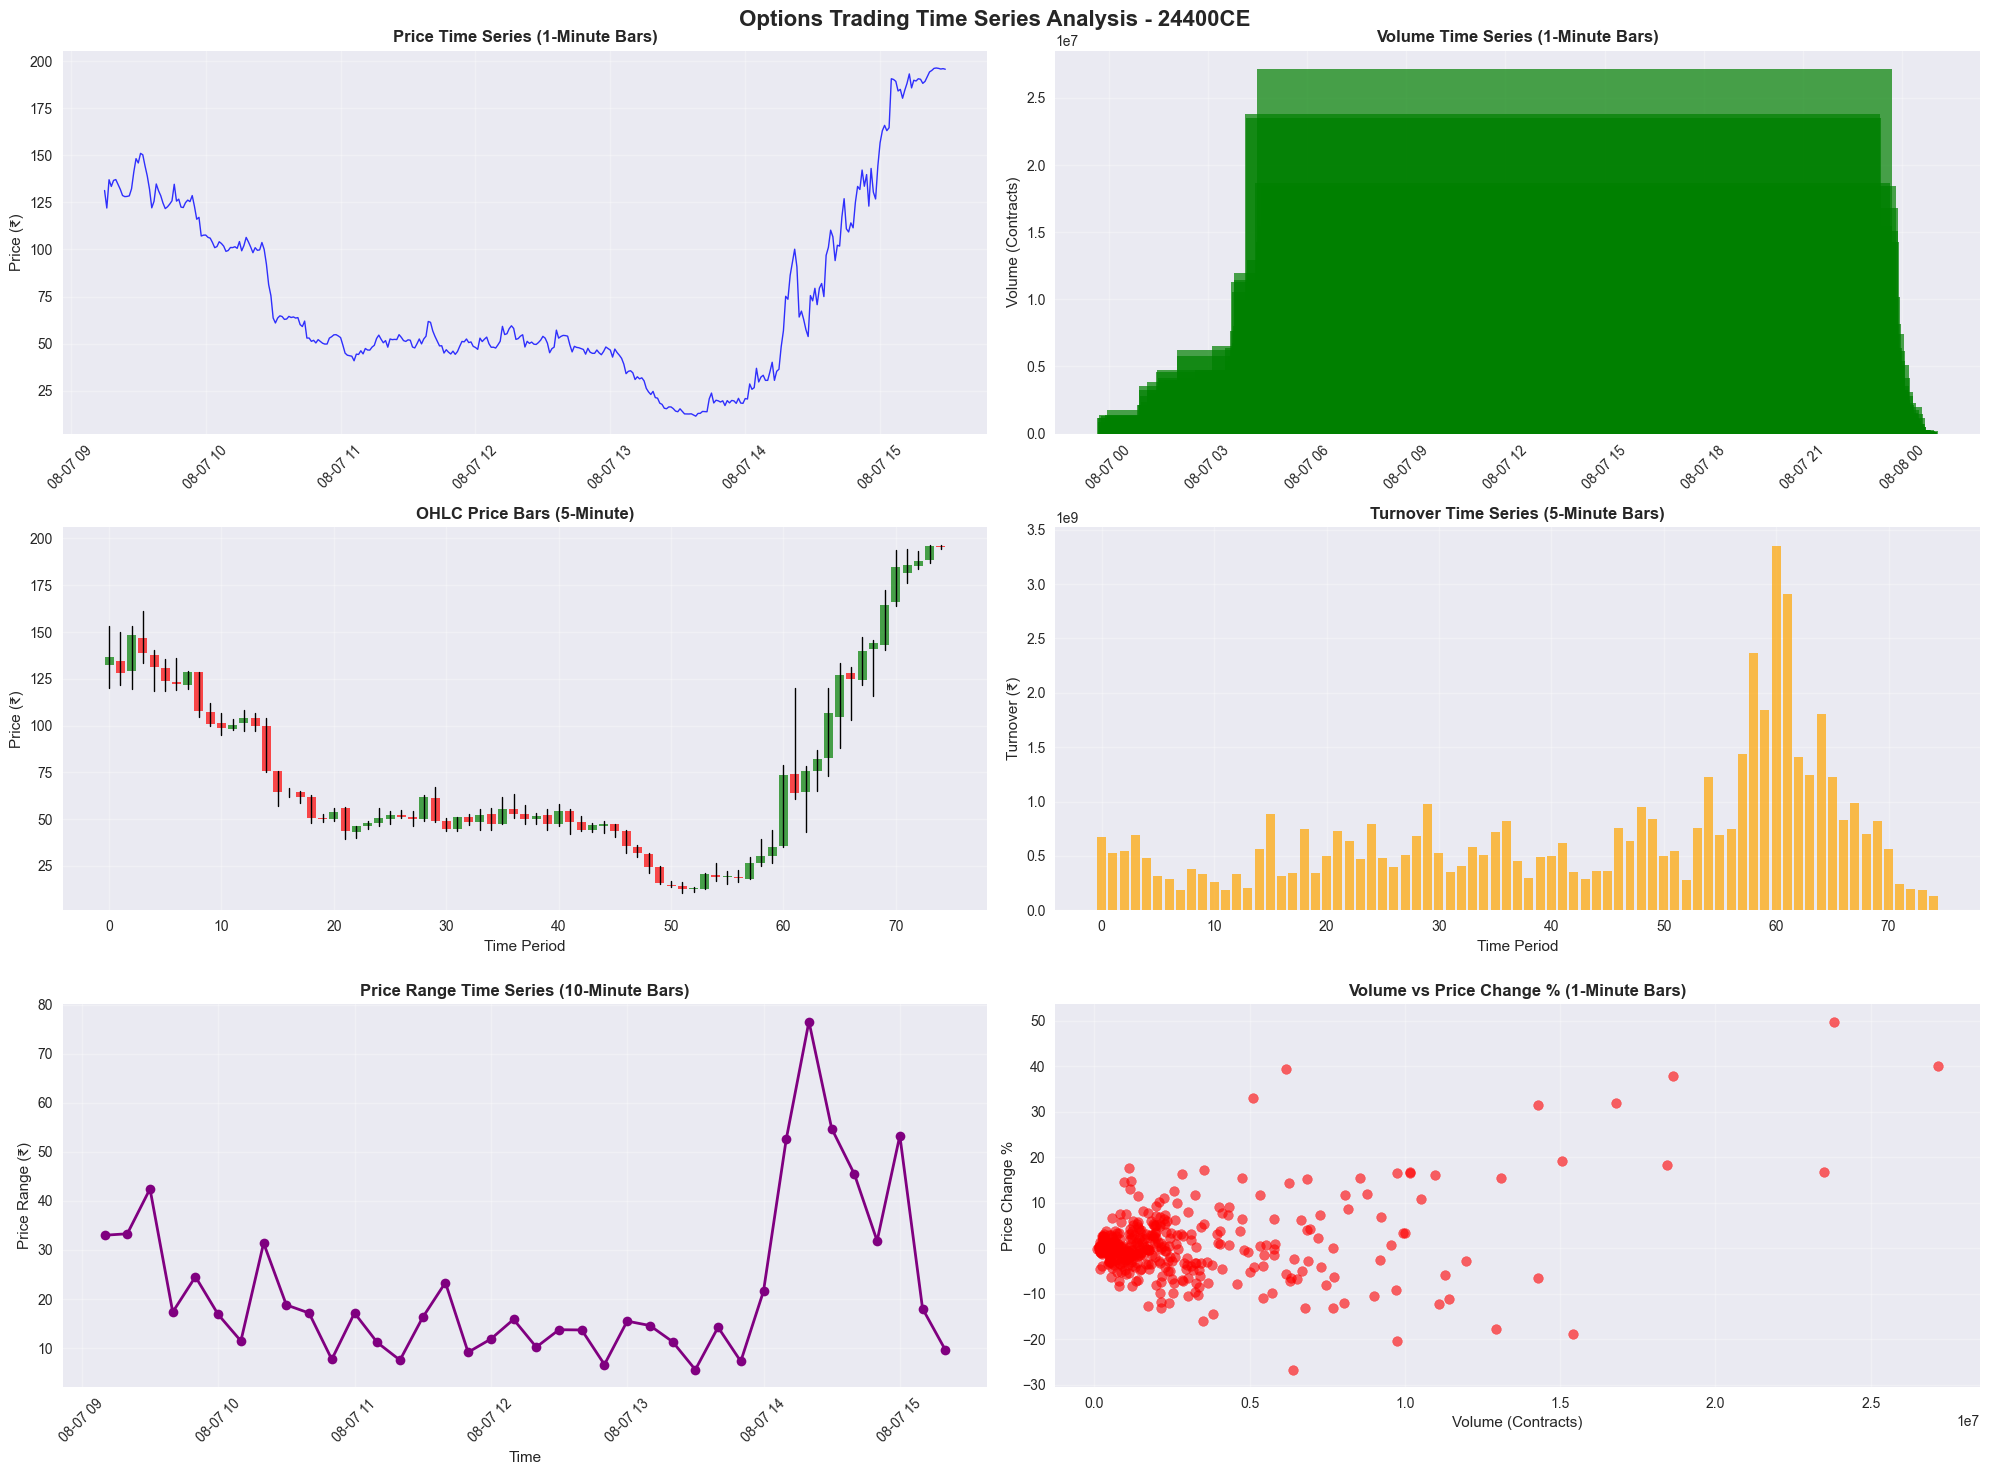

5. ADDITIONAL TIME-BASED ANALYSIS
📊 Hourly Trading Summary:
                       open   close    high     low  mean_price     volume  \
date                                                                         
2025-08-07 09:00:00  132.40  107.60  161.00  104.85  129.850638   30996675   
2025-08-07 10:00:00  107.40   54.10  111.95   47.85   78.937845   74187900   
2025-08-07 11:00:00   55.85   48.60   67.30   39.50   49.783277  139192650   
2025-08-07 12:00:00   48.75   47.40   63.25   41.90   50.487410  117622950   
2025-08-07 13:00:00   47.35   18.35   47.70   10.60   22.608091  404775225   
2025-08-07 14:00:00   17.95  144.25  147.55   17.80   80.157361  366542850   
2025-08-07 15:00:00  143.30  195.65  196.65  140.50  184.086319   12217800   

                         turnover  price_change  price_change_pct  
date                                                               
2025-08-07 09:00:00  4.092091e+09        -24.80        -18.731118  
2025-08-07 10:00:00  5.025580e+09

In [5]:
# Time-Based Aggregations & Resampling
print("=== TIME-BASED AGGREGATIONS & RESAMPLING ===")
print()

# 1. Create time-based aggregations
print("1. CREATING TIME-BASED AGGREGATIONS")
print("=" * 60)

# Set the date column as index for resampling
df_temp = df.set_index('date')

# Create different time intervals
intervals = {
    '1min': '1T',
    '5min': '5T', 
    '10min': '10T',
    '15min': '15T',
    '30min': '30T'
}

# Dictionary to store resampled dataframes
resampled_data = {}

for interval_name, interval_code in intervals.items():
    print(f"Creating {interval_name} bars...")
    
    # Resample and aggregate using separate operations
    resampled = df_temp.resample(interval_code).agg({
        'price': ['first', 'max', 'min', 'last', 'mean'],
        'qty': 'sum',
        'trnvr': 'sum',
        'cum_trnvr': 'last'
    })
    
    # Flatten column names
    resampled.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in resampled.columns]
    
    # Rename price columns to OHLC format
    resampled = resampled.rename(columns={
        'price_first': 'price_open',
        'price_max': 'price_high',
        'price_min': 'price_low',
        'price_last': 'price_close',
        'price_mean': 'price_mean',
        'qty_sum': 'volume',
        'trnvr_sum': 'turnover'
    })
    
    # Add derived columns
    resampled['price_range'] = resampled['price_high'] - resampled['price_low']
    resampled['price_range_pct'] = (resampled['price_range'] / resampled['price_low']) * 100
    resampled['price_change'] = resampled['price_close'] - resampled['price_open']
    resampled['price_change_pct'] = (resampled['price_change'] / resampled['price_open']) * 100
    
    # Remove rows with no data
    resampled = resampled.dropna()
    
    resampled_data[interval_name] = resampled
    
    print(f"✅ {interval_name}: {len(resampled)} bars created")
    print(f"   Time range: {resampled.index.min()} to {resampled.index.max()}")
    print()

# 2. Display sample of resampled data
print("2. SAMPLE OF RESAMPLED DATA")
print("=" * 60)

# Show 1-minute bars as example
print("📊 1-Minute Bars (First 10 rows):")
print(resampled_data['1min'].head(10))
print()

print("📊 5-Minute Bars (First 5 rows):")
print(resampled_data['5min'].head())
print()

# 3. Summary statistics for different intervals
print("3. SUMMARY STATISTICS BY INTERVAL")
print("=" * 60)

summary_stats = {}
for interval_name, data in resampled_data.items():
    stats = {
        'Total Bars': len(data),
        'Avg Volume per Bar': data['volume'].mean(),
        'Max Volume per Bar': data['volume'].max(),
        'Avg Turnover per Bar': data['turnover'].mean(),
        'Max Turnover per Bar': data['turnover'].max(),
        'Avg Price Range': data['price_range'].mean(),
        'Max Price Range': data['price_range'].max(),
        'Avg Price Change %': data['price_change_pct'].abs().mean(),
        'Max Price Change %': data['price_change_pct'].abs().max()
    }
    summary_stats[interval_name] = stats

summary_df = pd.DataFrame(summary_stats).round(2)
print(summary_df)
print()

# 4. Plotting Time Series
print("4. PLOTTING TIME SERIES")
print("=" * 60)

# Set up the plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Options Trading Time Series Analysis - 24400CE', fontsize=16, fontweight='bold')

# 1. Price Time Series (1-min bars)
ax1 = axes[0, 0]
data_1min = resampled_data['1min']
ax1.plot(data_1min.index, data_1min['price_close'], linewidth=1, color='blue', alpha=0.8)
ax1.set_title('Price Time Series (1-Minute Bars)', fontweight='bold')
ax1.set_ylabel('Price (₹)')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Volume Time Series (1-min bars)
ax2 = axes[0, 1]
ax2.bar(data_1min.index, data_1min['volume'], alpha=0.7, color='green')
ax2.set_title('Volume Time Series (1-Minute Bars)', fontweight='bold')
ax2.set_ylabel('Volume (Contracts)')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. OHLC Candlestick-like (5-min bars)
ax3 = axes[1, 0]
data_5min = resampled_data['5min']
for i, (idx, row) in enumerate(data_5min.iterrows()):
    # High-Low line
    ax3.plot([i, i], [row['price_low'], row['price_high']], color='black', linewidth=1)
    # Open-Close body
    if row['price_close'] >= row['price_open']:
        color = 'green'
        body_height = row['price_close'] - row['price_open']
        body_bottom = row['price_open']
    else:
        color = 'red'
        body_height = row['price_open'] - row['price_close']
        body_bottom = row['price_close']
    
    ax3.bar(i, body_height, bottom=body_bottom, color=color, alpha=0.7, width=0.8)

ax3.set_title('OHLC Price Bars (5-Minute)', fontweight='bold')
ax3.set_ylabel('Price (₹)')
ax3.set_xlabel('Time Period')
ax3.grid(True, alpha=0.3)

# 4. Turnover Time Series (5-min bars)
ax4 = axes[1, 1]
ax4.bar(range(len(data_5min)), data_5min['turnover'], alpha=0.7, color='orange')
ax4.set_title('Turnover Time Series (5-Minute Bars)', fontweight='bold')
ax4.set_ylabel('Turnover (₹)')
ax4.set_xlabel('Time Period')
ax4.grid(True, alpha=0.3)

# 5. Price Range Analysis (10-min bars)
ax5 = axes[2, 0]
data_10min = resampled_data['10min']
ax5.plot(data_10min.index, data_10min['price_range'], linewidth=2, color='purple', marker='o')
ax5.set_title('Price Range Time Series (10-Minute Bars)', fontweight='bold')
ax5.set_ylabel('Price Range (₹)')
ax5.set_xlabel('Time')
ax5.grid(True, alpha=0.3)
ax5.tick_params(axis='x', rotation=45)

# 6. Volume vs Price Change Scatter
ax6 = axes[2, 1]
ax6.scatter(data_1min['volume'], data_1min['price_change_pct'], alpha=0.6, color='red')
ax6.set_title('Volume vs Price Change % (1-Minute Bars)', fontweight='bold')
ax6.set_xlabel('Volume (Contracts)')
ax6.set_ylabel('Price Change %')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Additional Analysis
print("5. ADDITIONAL TIME-BASED ANALYSIS")
print("=" * 60)

# Hourly analysis
hourly_data = df_temp.resample('H').agg({
    'price': ['first', 'last', 'max', 'min', 'mean'],
    'qty': 'sum',
    'trnvr': 'sum'
}).dropna()

hourly_data.columns = ['open', 'close', 'high', 'low', 'mean_price', 'volume', 'turnover']
hourly_data['price_change'] = hourly_data['close'] - hourly_data['open']
hourly_data['price_change_pct'] = (hourly_data['price_change'] / hourly_data['open']) * 100

print("📊 Hourly Trading Summary:")
print(hourly_data)
print()

# Peak trading hours analysis
print("�� Peak Trading Hours Analysis:")
hourly_volume = df.groupby(df['date'].dt.hour)['qty'].sum()
peak_hour = hourly_volume.idxmax()
print(f"Peak trading hour: {peak_hour}:00 ({hourly_volume[peak_hour]:,.0f} contracts)")
print(f"Lowest trading hour: {hourly_volume.idxmin()}:00 ({hourly_volume.min():,.0f} contracts)")

# Volume distribution by hour
print("\n📊 Volume Distribution by Hour:")
for hour in sorted(hourly_volume.index):
    print(f"  {hour:02d}:00 - {hourly_volume[hour]:,.0f} contracts ({hourly_volume[hour]/hourly_volume.sum()*100:.1f}%)")

print()

# 6. Save resampled data for further analysis
print("6. SAVING RESAMPLED DATA")
print("=" * 60)

# Save 1-minute and 5-minute data for easy access
df_1min = resampled_data['1min'].reset_index()
df_5min = resampled_data['5min'].reset_index()

print("✅ Resampled dataframes available:")
print(f"   - df_1min: {len(df_1min)} rows (1-minute bars)")
print(f"   - df_5min: {len(df_5min)} rows (5-minute bars)")
print(f"   - resampled_data: Dictionary with all intervals")

# Display column names for reference
print("\n📋 Available columns in resampled data:")
print("   - price_open, price_high, price_low, price_close, price_mean")
print("   - volume, turnover")
print("   - price_range, price_range_pct, price_change, price_change_pct")

print("\n" + "="*60)
print("✅ TIME-BASED AGGREGATIONS & RESAMPLING COMPLETED")
print("="*60)